In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection


## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, confusion_matrix, precision_recall_curve, \
average_precision_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
import xgboost as xgb

In [0]:
# Custom Functions
import curves as C

In [0]:
dataset = pd.read_csv('creditcard.csv')
dataset_X = dataset.drop(['Class'], axis = 1)
dataset_y = dataset['Class']

## Splitting the dataset into the Training set and Test set

In [0]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)
    print('train-set size: ', len(y_train), 
          '\ntest-set size: ', len(y_test))    
    print('fraud cases in train-set', sum(y_train),
          '\nfraud cases in test-set: ', sum(y_test))
    return X_train, X_test, y_train, y_test

## Define function to get predictions

In [0]:
def get_predictions(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, cmap = "coolwarm", annot = True, linewidths = 0.5)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()
    print('==============================')
    print(cm)
    print('==============================')
    print('accuracy = {}'.format(accuracy_score(y_true, y_pred)))
    print('precision = {}'.format(precision_score(y_true, y_pred)))
    print('recall = {}'.format(recall_score(y_true, y_pred)))
    print('f1 score = {}'.format(f1_score(y_true, y_pred)))
    print('==============================')
    print(classification_report(y_true, y_pred))

## Feature importance plot

In [0]:
def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
    plt.figure(figsize = (15, 8))
    plt.title('Features importance', fontsize = 14)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation = 45)
    plt.show()

## Case 1: Drop 'Time', 'Amount'

In [0]:
drop_list = ['Time', 'Amount']
# drop_list = ['Time', 'Amount', 'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8']
X = dataset_X.drop(drop_list, axis = 1)
predictor_name = X.columns
X = X.values
y = dataset_y.values
print(predictor_name)
X_train, X_test, y_train, y_test = split_data(X, y)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
train-set size:  199364 
test-set size:  85443
fraud cases in train-set 344 
fraud cases in test-set:  148


 ## 1. Extreme Gradient Boosting (XGB)

### 1.1 XGB - Without hyperparameters tuning

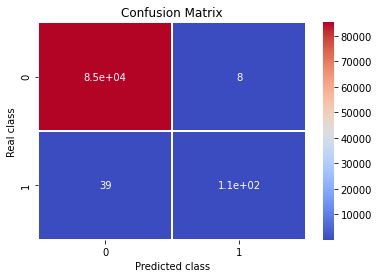

[[85287     8]
 [   39   109]]
accuracy = 0.9994499256814484
precision = 0.9316239316239316
recall = 0.7364864864864865
f1 score = 0.8226415094339623
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.74      0.82       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, n_estimators = 200)
xgb_clf.fit(X_train, y_train)
y_score = xgb_clf.predict_proba(X_test)[:,1]
y_pred = xgb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

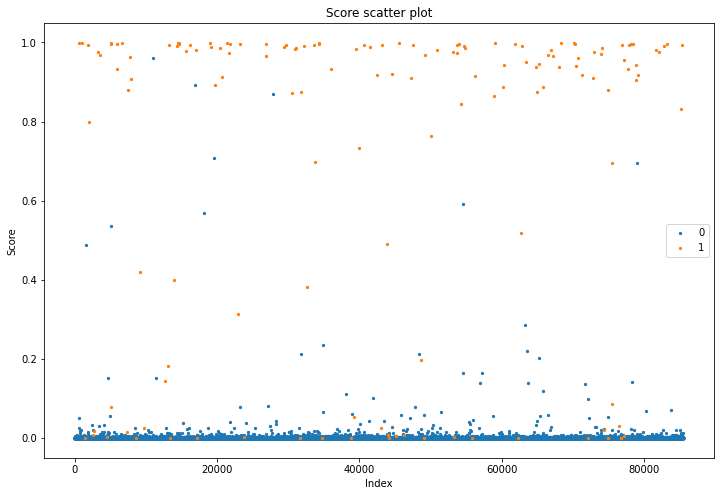

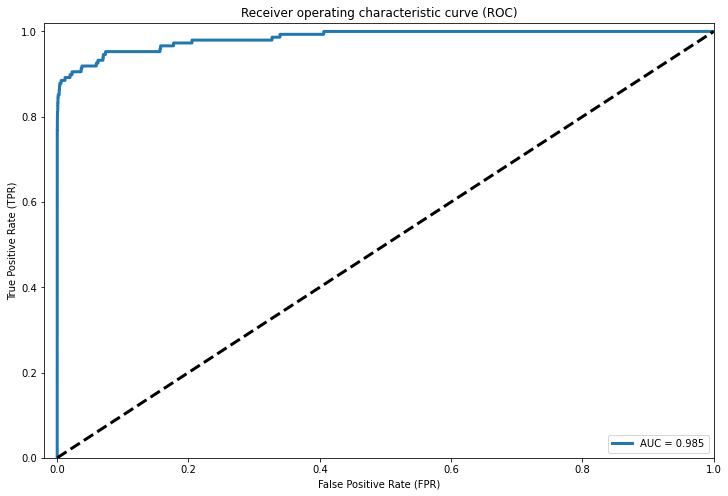

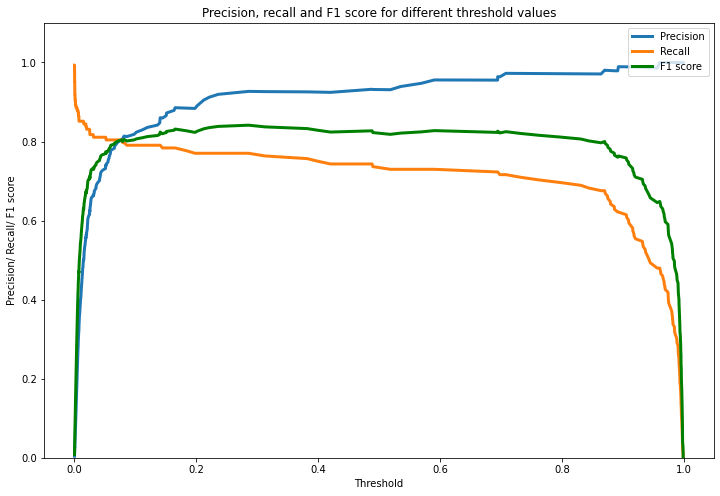

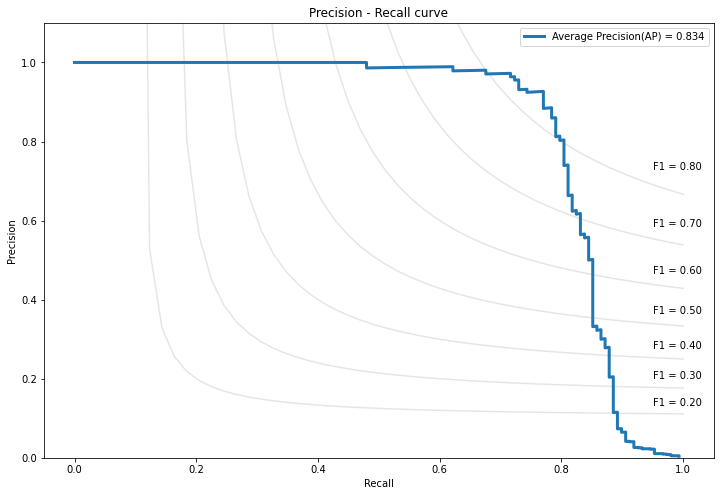

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_xgb, tpr_xgb, roc_auc_xgb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_xgb, recall_xgb, threshold_xgb, f1_scores_xgb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_xgb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

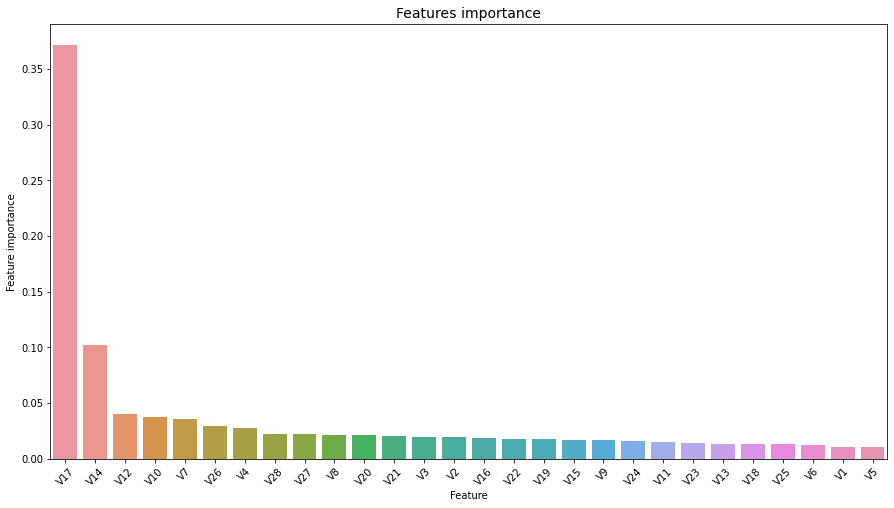

In [0]:
# Plot Feature importance
plot_feature_importance(model = xgb_clf, predictors = predictor_name)

### 1.2 Grid Search CV to optimize 'F1'

In [0]:
# Applying Grid Search to find the best model and the best parameters
classifier = xgb.XGBClassifier()
# parameter = [{'n_estimators': [100, 200, 300, 400]}]
parameter = [{'n_estimators': [100]}]
skf = StratifiedKFold(n_splits = 5, random_state = 0)
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameter,
                           scoring = 'f1',
                           cv = skf.split(X_train, y_train),
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
results = grid_search.cv_results_
best_parameters

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


{'n_estimators': 100}

### 1.3 XGB with best parameters

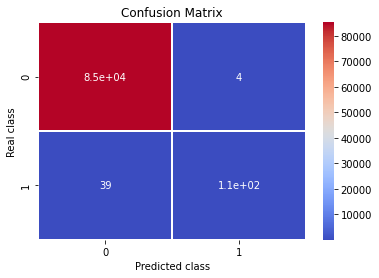

[[85291     4]
 [   39   109]]
accuracy = 0.9994967405170698
precision = 0.9646017699115044
recall = 0.7364864864864865
f1 score = 0.8352490421455939
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.74      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, n_estimators = 400)
xgb_clf.fit(X_train, y_train)
y_score = xgb_clf.predict_proba(X_test)[:,1]
y_pred = xgb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

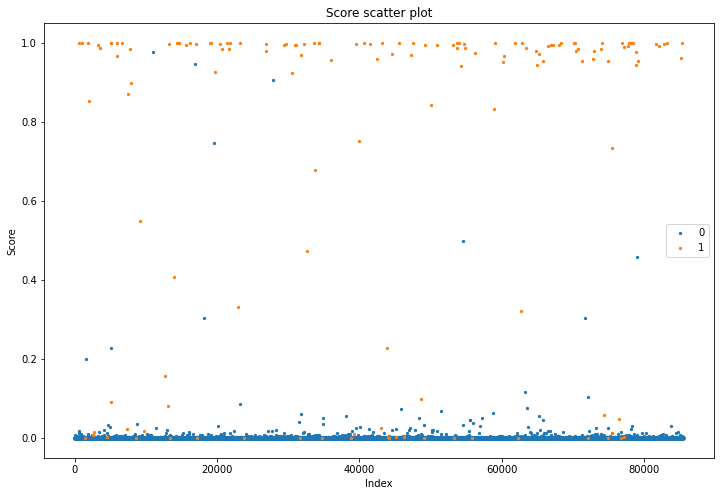

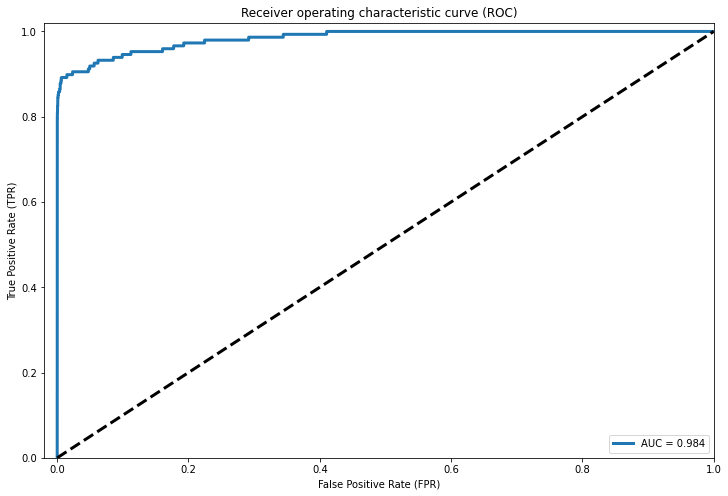

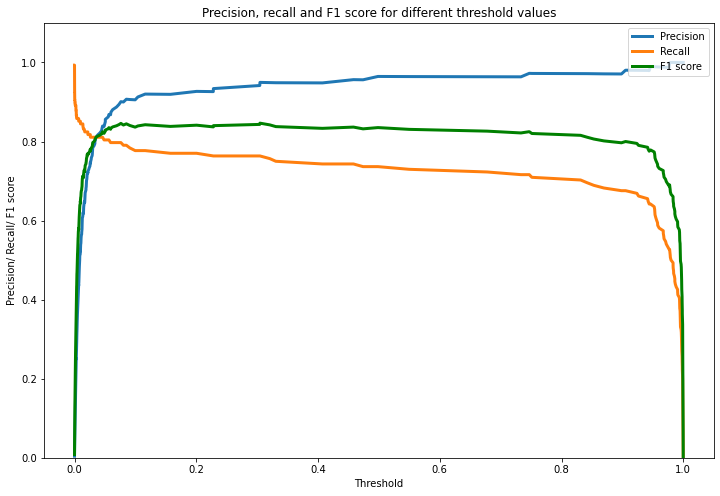

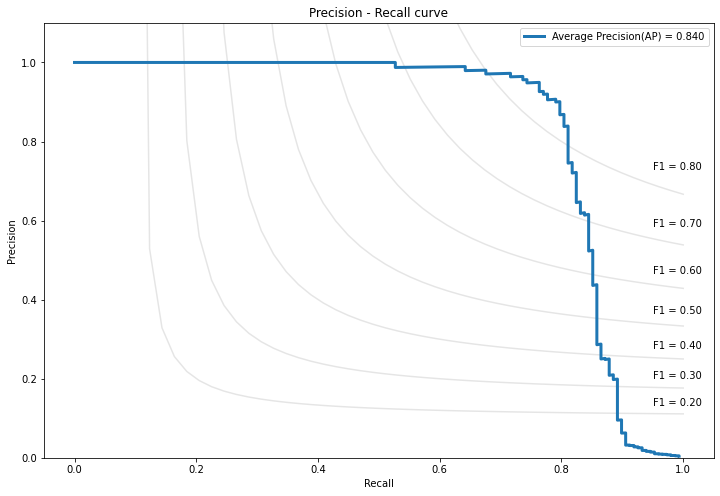

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_xgb, tpr_xgb, roc_auc_xgb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_xgb, recall_xgb, threshold_xgb, f1_scores_xgb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_xgb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

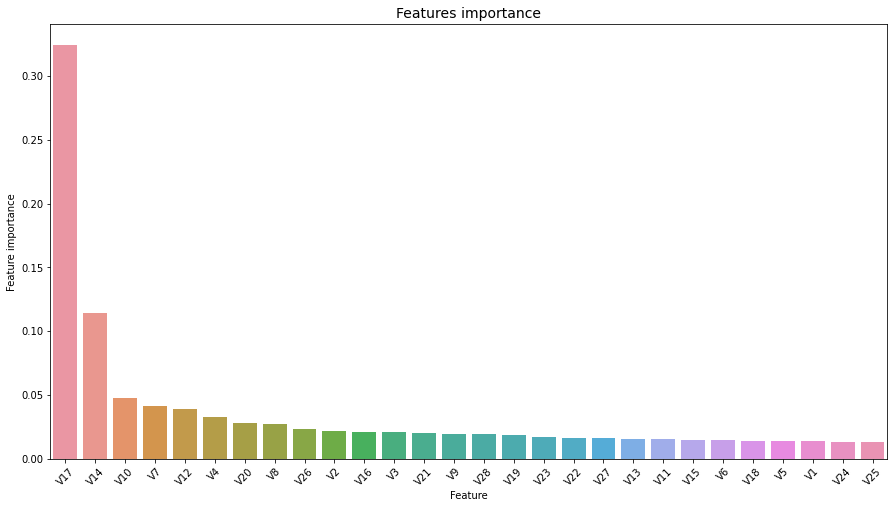

In [0]:
# Plot Feature importance
plot_feature_importance(model = xgb_clf, predictors = predictor_name)